# Notebook Content

This notebook contains:<br>
    1. Reading data.<br>
    2. Taking out a sample.<br>
    3. Dropping some columns.<br>
    4. Handling nulls & duplicates.<br>
    5. Fixing timestamp issue.<br>
    6. Merging classes.<br>
    7. Detecting the relationship between target and features through correlation plots.<br>
    8. Saving into sql.<br>

# Exploratory Data Analysis

### Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sqlite3 as sql

### Reading data

The data is seperated on 4 differenbt csv files and each file indicates the device and the type of sensor. <br>
**Device:**<br>
    -Phone.<br>
    -Watch.<br>
**Sensor:**<br>
    -Accelerometer.<br>
    -gyroscope.<br>

In [7]:
Phones_accelerometer = pd.read_csv('Data/Phones_accelerometer.csv')
Phones_gyroscope = pd.read_csv('Data/Phones_gyroscope.csv')
Watch_accelerometer = pd.read_csv('Data/Watch_accelerometer.csv')
Watch_gyroscope = pd.read_csv('Data/Watch_gyroscope.csv')

### Intitiating new column

A new column is added to combine the sensor and the device all together.

In [8]:
Phones_accelerometer["sensor"] = "phone_acc"
Phones_gyroscope["sensor"] = "phone_gyro"
Watch_accelerometer["sensor"] = "watch_acc"
Watch_gyroscope["sensor"] = "watch_gyro"

In [9]:
# Concatenating all dataframes into one after adding the new 'sensor' column
all_data_i = pd.concat([Phones_accelerometer,Phones_gyroscope,Watch_accelerometer,Watch_gyroscope],axis=0)

### Picking out a sample

Originally the whole dataset was around **29096999** rows but for the sake of the running time a sample of 500000 rows were taken.<br>
Later on the model selection phase the sample started with 10000 and was increasing after each iteration until 200000 sample, After that
there were no changes present.

In [10]:
all_data = all_data_i.sample(500000,replace=True, random_state = 77)

In [11]:
# Dropping the index column
all_data.drop('Index', axis = 1, inplace = True)

In [12]:
all_data.shape

(500000, 10)

### Dropping nulls

In [13]:
all_data.dropna(inplace = True)

In [14]:
all_data.shape # Size of data changed

(431641, 10)

### Dropping nulls

In [15]:
all_data[all_data.duplicated()] # Viewing the rows that contain nulls

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt,sensor
9423223,1424688063583,44428994636000,-1.704672,2.566584,8.245630,g,s3,s3_1,stairsdown,phone_acc
12870803,1424777560829,3230841809000,-5.056491,0.306454,11.338798,i,samsungold,samsungold_1,stairsup,phone_acc
9178097,1424687330505,1424687328502446586,-0.000626,-0.002930,0.000244,g,nexus4,nexus4_1,sit,phone_gyro
2663461,1424779164185,290347196234573,-9.344070,-3.340729,-0.105545,f,lgwatch,lgwatch_1,stand,watch_acc
5071151,1424781954107,347267193962000,-3.217807,-0.086191,9.088389,d,s3,s3_2,stand,phone_acc
...,...,...,...,...,...,...,...,...,...,...
2576725,1424780300384,14915100158000,8.357559,-5.971737,4.069544,f,gear,gear_1,stairsup,watch_acc
11253019,1424699969067,1424701815120871346,0.213058,-0.053284,-0.347000,h,nexus4,nexus4_2,walk,phone_gyro
13845435,1424777514787,2098122868000,0.016103,0.418912,-0.198111,i,s3mini,s3mini_1,stairsdown,phone_gyro
1000204,1424696716494,274320366683000,0.010385,0.000611,0.027794,a,s3,s3_2,stand,phone_gyro


In [16]:
all_data.drop_duplicates(inplace = True) # Dropping all nulls

In [17]:
all_data.shape # Shape changed once more

(428460, 10)

### Fixing timestamp issue

There are a couple of columns in the dataset that include timestamps **Arrival Time** & **Creation Time** they need to be broken down into date and time for easier handling and for better understanding.

In [18]:
# Converting each rows in the arrival time column to the corresponding time
all_data.loc[:,'Arrival_Time_'] = all_data.Arrival_Time.apply(lambda x: datetime.datetime.fromtimestamp(x/1e3).strftime('%H:%M'))

In [19]:
# Converting each rows in the arrival time column to the corresponding date
all_data.loc[:,'Arrival_Date'] = all_data.Arrival_Time.apply(lambda x: datetime.datetime.fromtimestamp(x/1e3).strftime('%Y-%m-%d'))

In [20]:
# Dropping the old arrival time column and the creation column since its now irrelevent
all_data.drop(['Arrival_Time','Creation_Time'], axis = 1, inplace = True)

In [21]:
# Renaming columns
all_data.rename({'Arrival_Time_': 'Arrival_Time','gt':'Activity'}, axis=1, inplace = True)

In [22]:
all_data.sample(5) # Dataset after solving the timesstamp issue

,x,y,z,User,Model,Device,Activity,sensor,Arrival_Time,Arrival_Date
2807600,8.887166,0.766135,4.443583,b,samsungold,samsungold_2,sit,phone_acc,16:41,2015-02-24
1759399,8.799118,-7.742035,2.179611,d,lgwatch,lgwatch_1,stairsdown,watch_acc,15:59,2015-02-24
1050047,-0.169754,0.047943,0.035706,c,lgwatch,lgwatch_1,stand,watch_gyro,15:16,2015-02-23
7644099,7.906448,-0.676636,5.894028,f,nexus4,nexus4_2,sit,phone_acc,15:03,2015-02-24
12321601,-1.599327,0.593762,8.475474,i,s3,s3_1,walk,phone_acc,14:27,2015-02-24


## Target-Feature Relationship

Pairplot was done to distinguish the features that better seperate the data regarding to the target. But, here stemms the first
probelm. A clear overlap of all 6 classes is present in all features. To solve this issue all the 6 classes will be merged
into 2 classes.

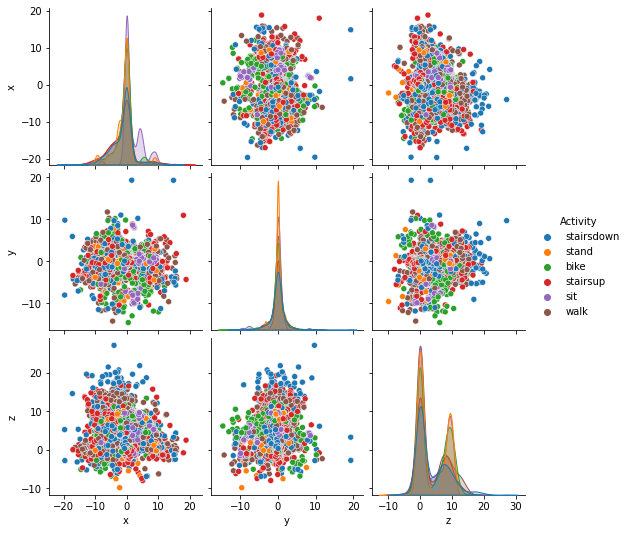

In [23]:
sns.pairplot(all_data.sample(10000), hue='Activity');

In [24]:
# Reduce the number of class. 
# Combine sitting and standing (Stationary)
all_data.loc[all_data['Activity'] == 'sit', 'Activity_Class'] = 0
all_data.loc[all_data['Activity'] == 'stand', 'Activity_Class'] = 0
# Combine walking and stair up and down (Moving)
all_data.loc[all_data['Activity'] == 'stairsup', 'Activity_Class'] = 1
all_data.loc[all_data['Activity'] == 'stairsdown', 'Activity_Class'] = 1
all_data.loc[all_data['Activity'] == 'bike', 'Activity_Class'] = 1
all_data.loc[all_data['Activity'] == 'walk', 'Activity_Class'] = 1

The project from this point onwards will tackle the data from a binary-class viewpoint instead of a multi-class viewpoint.

In [25]:
all_data.sample(5) #Dataset after adding the Activity Class column to represent the type of class

,x,y,z,User,Model,Device,Activity,sensor,Arrival_Time,Arrival_Date,Activity_Class
7426361,-1.642922,-1.905594,-0.277333,e,s3,s3_2,stairsup,phone_gyro,17:35,2015-02-24,1.0
9349595,4.165911,1.877054,8.839393,g,s3,s3_1,sit,phone_acc,13:27,2015-02-23,0.0
6149945,0.065506,-1.572845,9.647873,e,nexus4,nexus4_2,stairsdown,phone_acc,17:31,2015-02-24,1.0
7318245,-0.212887,0.007941,0.082161,e,s3,s3_2,walk,phone_gyro,17:24,2015-02-24,1.0
150907,-0.026932,-0.018921,-0.013443,a,lgwatch,lgwatch_1,sit,watch_gyro,16:12,2015-02-23,0.0


### Correlation

In [26]:
corr = all_data.corr()

In [27]:
corr

,x,y,z,Activity_Class
x,1.000000,-0.012391,-0.201783,-0.188602
y,-0.012391,1.000000,0.072293,0.003951
z,-0.201783,0.072293,1.000000,0.000045
Activity_Class,-0.188602,0.003951,0.000045,1.000000


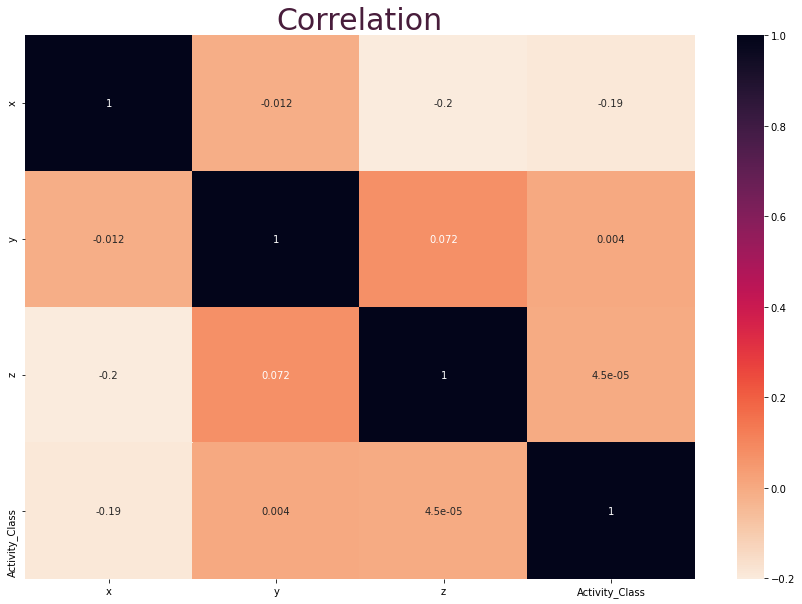

In [28]:
plt.figure(figsize = [15,10])
sns.heatmap(corr, annot = True, cmap = sns.cm.rocket_r );
plt.title('Correlation', color= '#481D3B', fontsize=30);

## Saving to Database

In [32]:
# Save our sets to database
all_data_conn = sql.connect('Data/All_data.db')
all_data.to_sql('All_data', all_data_conn)